# Adversarial Examplesのつくり方 (MNIST)

MNISTのAdversarial Examplesを作ります。  
MNISTとは、下図のようなそれぞれ28x28(x1)のサイズを持つグレースケールの手書き数字画像です。  
よく深層学習の「Hello, World」として利用されています。  
一般に、この画像群を使い、「１」の画像を１、「２」の画像であれば２というように分類します。  
今回は、ちゃんと１と分類される「１」画像に  
僅かなノイズ（摂動）を加えて別の画像に誤分類される画像を作ります。  

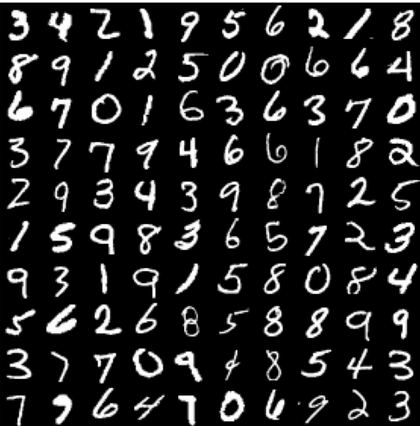

In [1]:
from IPython.display import Image, display
Image("../img/mnist.png")

In [2]:
import numpy as np
import os
import PIL
import matplotlib.pyplot as plt
import matplotlib.font_manager
fontprop = matplotlib.font_manager.FontProperties(fname="/usr/share/fonts/truetype/fonts-japanese-gothic.ttf")

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as dt

from torchvision.datasets import MNIST

torch.manual_seed(11)

model_path = "../img/target_cnn.pth"
use_gpu = torch.cuda.is_available()

## 騙す用のCNNモデル（分類器）を用意
下図のような構成のCNN学習モデルに対して攻撃を行う  

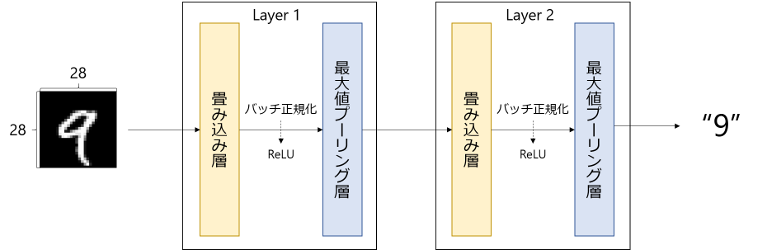

In [3]:
Image("../img/architecture.png")

In [4]:
class CNN(nn.Module):
    '''
    攻撃対象のCNNモデル
    '''

    def __init__(self):
        super(CNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc = nn.Linear(32 * 7 * 7, 23)

    def forward(self, x):
        # 順伝搬
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out

## 訓練
6万枚の訓練用画像を使い学習

In [5]:
def train(model, img, lbls, num_epochs=100, batch_size=16, lr=0.01, use_gpu=False):
    '''
    学習モデルを訓練する関数
    :param model: 学習モデル
    :param img: 画像
    :param lbls: 正解ラベル
    :param num_epochs: エポック数
    :param batch_size: バッチサイズ
    :param lr: 学習率
    :param use_gpu: GPUが使えるかのフラグ
    :return: 学習済みモデル
    '''
    # 訓練モード
    model.train()

    # GPUが使えるならGPUで動作させる
    if use_gpu:
        print('gpu is available')
        model.cuda()

    img.unsqueeze_(1)
    img = img.type(torch.FloatTensor)
    img = img

    # データセットを作成
    train_data = torch.utils.data.TensorDataset(img, lbls)
    train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

    # 損失関数と最適化方法を指定
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    correct = 0
    length = 0

    # epoch回学習
    for epoch in range(num_epochs):

        running_loss = 0

        # ミニバッチを学習
        for i, (images, labels) in enumerate(train_loader):

            if use_gpu:
                images = images.cuda()
                labels = labels.cuda()

            optimizer.zero_grad()

            outputs = model(images)

            # 交差エントロピー
            loss = criterion(outputs, labels)

            # 逆伝搬
            loss.backward()

            # パラメータ更新
            optimizer.step()

            running_loss += loss.item()
            _, pred = torch.max(outputs.data, 1)
            correct += (labels.data == pred).sum()
            length += labels.size(0)

        # エポック毎の誤差
        training_loss = running_loss / len(train_loader)

        acc = correct.cpu().data.numpy() / length
               
        # 10エポックごとに損失表示
        if (epoch) % 1 == 0:
            print('Epoch [%d/%d], Loss: %f, Acc: %f'
                  % (epoch + 1, num_epochs, training_loss, acc))
    
    torch.save(model.state_dict(), model_path)
    
    return model

###################################################################################################
# 実行フェーズ
##################################################################################################

# MNISTを用意する
mnist = MNIST('~/tmp/mnist', train=True, download=True)
print("入力サイズ:", mnist.train_data.size())

cnn = CNN()
# CNNを10エポック分だけ学習
# このモデルは保存される
model = train(cnn, mnist.train_data, mnist.train_labels, 10, use_gpu=True)

入力サイズ: torch.Size([60000, 28, 28])
gpu is available
Epoch [1/10], Loss: 0.110698, Acc: 0.965933
Epoch [2/10], Loss: 0.059608, Acc: 0.973867
Epoch [3/10], Loss: 0.046052, Acc: 0.978006
Epoch [4/10], Loss: 0.045095, Acc: 0.980071
Epoch [5/10], Loss: 0.038954, Acc: 0.981750
Epoch [6/10], Loss: 0.035313, Acc: 0.982997
Epoch [7/10], Loss: 0.035408, Acc: 0.984007
Epoch [8/10], Loss: 0.031804, Acc: 0.984840
Epoch [9/10], Loss: 0.030515, Acc: 0.985528
Epoch [10/10], Loss: 0.029432, Acc: 0.986148


## 通常のAdversarial Examplesのつくりかた
1. 狙ったクラスへ(ターゲットクラス)と誤分類させる（ベースライン）  
2. FGSMで高速に誤分類させる

In [6]:
def load_model(model):
        '''
        学習済みモデルを読み込む関数
        '''
        param = torch.load(model_path)
        model = CNN()
        model.load_state_dict(param)
        
        return model


class Attack:
    '''
    Adversarial Examplesを作成するクラス
    '''
    def __init__(self, model, use_gpu=False):
        # さっき作ったモデルを読み込む
        self.use_gpu = use_gpu
        self.model = model
    
    def baseline(self, x, y_true, y_target, num_iter):
        '''
        （１）ベースライン手法でAdversarial Examplesを作成する関数
        :x: オリジナル画像
        :y_true: 正解ラベル（クラスインデックス）
        :y_target: ターゲットクラス（クラスインデックス）、このクラスに誤分類されることを目指す
        :num_iter: 最大イテレーション数（この回数試しても、誤分類されなければ諦める）
        
        :return: Advimg, Advimgの分類結果, 正解クラス, 摂動
        '''
        
        # 重みパラメータの更新はしない
        for param in self.model.parameters():
            param.requires_grad = False
        
        # オリジナル画像データを退避させる
        orig = x
        
        # ノイズ（摂動）、初期値はオール0
        noise = torch.zeros(1, 1, 28, 28).float()
        
        # ターゲットクラス
        y_target = torch.LongTensor([y_target])
        
        # GPUへ転送
        if self.use_gpu:
            self.model = self.model.cuda()
            orig = orig.cuda()
            x = x.cuda()
            noise = noise.cuda()
            y_true = y_true.cuda()
            y_target = y_target.cuda()
        
        # ノイズが更新パラメータ
        noise.requires_grad_()
        
        # 初期状態でちゃんと分類されているか確認
        print(f"first_pred: {np.argmax(self.model(x).cpu().data.numpy())}")
        
        # 更新方法を決定
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(params=[noise])

        for i in range(num_iter):
            
            # Adv_img = オリジナル + 摂動
            x = torch.clamp(orig + noise, 0, 255)
            
            # ターゲットクラスへの勾配降下法を行う
            outputs = self.model(x)
            loss = criterion(outputs, y_target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # 画像の表現範囲を超えないようにクリッピングする
            adv_x = torch.clamp(orig + noise, 0, 255)
            
            # 摂動加算後の分類結果
            y_pred_adv = np.argmax(self.model(adv_x).cpu().data.numpy())
            
            # 1000回毎に結果を出力
            if i % 1000 == 0:
                print(f"iter: {i},  pred: {y_pred_adv}, Loss: {loss}")
            
            # 誤分類された時点でノイズの更新を終了
            y_true_np = y_true.cpu().data.numpy()[0]
            y_target_np = y_target.cpu().data.numpy()[0]
            
            if y_target_np == y_pred_adv:
                print(f'iter: {i}, The image was changed {y_true_np} to {y_pred_adv}')
                break

        return adv_x.cpu().data.numpy().squeeze(), y_pred_adv, y_target_np, y_true_np, noise.cpu().data.numpy().squeeze()
    
    
    def fgsm(self, x, y_true, y_target, epsilon, num_iter):
        '''
        （２）FGSMでAdversarial Examplesを作成する関数
        :x: オリジナル画像
        :y_true: 正解ラベル（クラスインデックス）
        :epsilon: ε(イプシロン)
        :num_iter: 最大イテレーション数（この回数試しても、誤分類されなければ諦める）
        
        :return: Advimg, Advimgの分類結果, 正解クラス, 摂動
        '''
        
        # 重みパラメータの更新はしない
        for param in self.model.parameters():
            param.requires_grad = False
        
        # オリジナル画像データを退避させる
        orig = x
        
        # GPUへ転送
        if self.use_gpu:
            self.model = self.model.cuda()
            orig = orig.cuda()
            x = x.cuda()
            y_true = y_true.cuda()
        
        # 入力画像を更新
        x.requires_grad_()
        
        # 初期状態できちんと分類されているか確認
        print(f"first_pred: {np.argmax(self.model(x).cpu().data.numpy())}")
        
        # 更新方法を決定
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(params=[x], lr=0.01)
        
        for i in range(num_iter):
            
            # 正解クラスに対する勾配を求める
            outputs = self.model(x)
            loss = criterion(outputs, y_true)
            optimizer.zero_grad()
            loss.backward()

            # 勾配上昇方向へ更新
            x_grad = torch.sign(x.grad.data)
            x = torch.clamp(x.data + epsilon * x_grad, 0, 255)
            x.requires_grad_()

            # 更新後の分類結果を確認
            y_pred_adv = np.argmax(self.model(x).cpu().data.numpy())
            
            # 摂動は元画像からの変化分
            noise = (orig - x).cpu().data.numpy()
            
            # 10回毎に結果表示
            if i % 1000 == 0:
                print(f"iter: {i},  pred: {y_pred_adv}, Loss: {loss}")
            
            # 誤分類させることに成功したら更新終了
            y_true_np = y_true.cpu().data.numpy()[0]
            if y_true_np != y_pred_adv:
                print(f'iter: {i}, The image was changed {y_true_np} to {y_pred_adv}')
                break

        return x.cpu().data.numpy().squeeze(), y_pred_adv, y_true_np, noise.squeeze()

正解ラベル:  5
出力クラス: 5


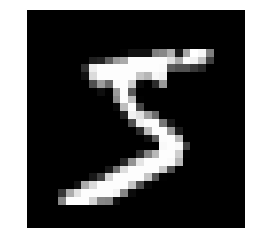

In [7]:
idx = 0
model = load_model(cnn)

#　画像を表示
plt.imshow(mnist.train_data[idx].numpy().squeeze(), cmap='gray')
plt.axis('off')

# 正解ラベルを表示
print("正解ラベル: ", mnist.train_labels[idx].numpy())
print('出力クラス:', torch.argmax(model(mnist.train_data[idx].view(1, 1, 28, 28).float())).numpy())

## ベースラインでAdversarial Examplesを作成

In [8]:
adv = Attack(model, use_gpu=True)

In [9]:
%%time

y_target = 9

adv_img, adv_pred, y_target_np, y_true_np, noise = \
                adv.baseline(mnist.train_data[idx].view(1, 1, 28, 28).float(), mnist.train_labels[idx].unsqueeze(0), y_target=y_target, num_iter=200000)

first_pred: 5
iter: 0,  pred: 5, Loss: 40.22614288330078
iter: 1000,  pred: 5, Loss: 39.59895324707031
iter: 2000,  pred: 5, Loss: 38.986419677734375
iter: 3000,  pred: 5, Loss: 38.49693298339844
iter: 4000,  pred: 5, Loss: 38.01422882080078
iter: 5000,  pred: 5, Loss: 37.54008865356445
iter: 6000,  pred: 5, Loss: 37.082393646240234
iter: 7000,  pred: 5, Loss: 36.63148498535156
iter: 8000,  pred: 5, Loss: 36.16381072998047
iter: 9000,  pred: 5, Loss: 35.691104888916016
iter: 10000,  pred: 5, Loss: 35.208152770996094
iter: 11000,  pred: 5, Loss: 34.74555206298828
iter: 12000,  pred: 5, Loss: 34.29152297973633
iter: 13000,  pred: 5, Loss: 33.83129119873047
iter: 14000,  pred: 5, Loss: 33.38238525390625
iter: 15000,  pred: 5, Loss: 32.94837188720703
iter: 16000,  pred: 5, Loss: 32.52337646484375
iter: 17000,  pred: 5, Loss: 32.09123229980469
iter: 18000,  pred: 5, Loss: 31.655376434326172
iter: 19000,  pred: 5, Loss: 31.21181869506836
iter: 20000,  pred: 5, Loss: 30.787580490112305
iter: 

### ほんとに誤分類されるか確認

In [10]:
model = load_model(cnn)

print('出力クラス:', torch.argmax(model(torch.Tensor(adv_img).view(1, 1, 28, 28).float())).numpy())

出力クラス: 9


Text(0.5,1,'Adversarial Example\nResult: 9')

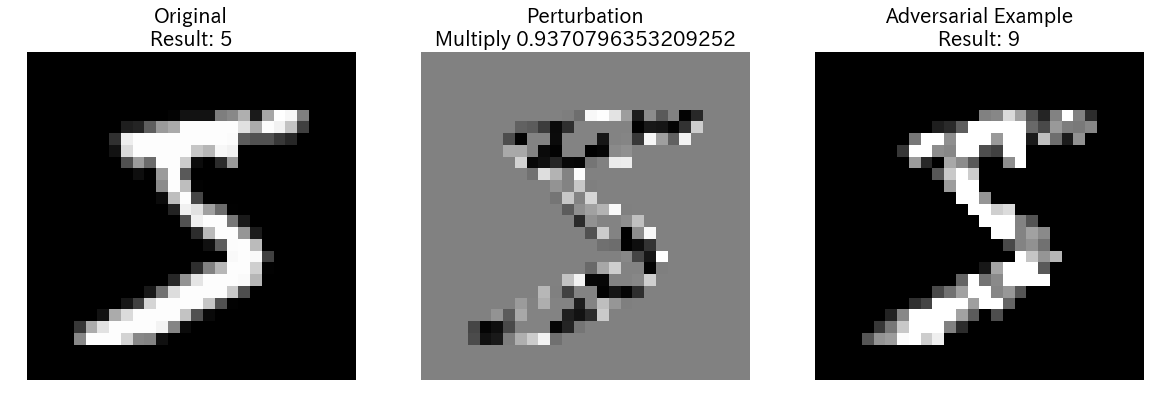

In [11]:
fig = plt.figure(figsize=(20, 10))

left = fig.add_subplot(131)
left.imshow(mnist.train_data[idx].numpy().squeeze(), cmap='gray')
left.axis('off')
left.set_title(f'Original\nResult: {y_true_np}', fontdict = {"fontproperties": fontprop, "fontsize": 20})

multiply = (np.max(noise) - np.min(noise)) / 255
middle = fig.add_subplot(132)
middle.imshow(noise, cmap='gray')
middle.axis('off')
middle.set_title(f'Perturbation\nMultiply {multiply}', fontdict = {"fontproperties": fontprop, "fontsize": 20})

right = fig.add_subplot(133)
right.imshow(adv_img, cmap='gray')
right.axis('off')
right.set_title(f'Adversarial Example\nResult: {adv_pred}', fontdict = {"fontproperties": fontprop, "fontsize": 20})

## FGSMでAdversarial Examplesをつくる

In [12]:
%%time

adv_img, adv_pred, y_true_np, noise = adv.fgsm(mnist.train_data[idx].view(1, 1, 28, 28).float(), mnist.train_labels[idx].unsqueeze(0), 5, 1e-2, 100000)

first_pred: 5
iter: 0,  pred: 5, Loss: 0.0
iter: 1000,  pred: 5, Loss: 1.1444091796875e-05
iter: 2000,  pred: 5, Loss: 0.1019582748413086
iter: 2256, The image was changed 5 to 3
CPU times: user 2.31 s, sys: 88 ms, total: 2.4 s
Wall time: 2.34 s


### ほんとに誤分類されるか確認

In [13]:
model = load_model(cnn)

print('出力クラス:', torch.argmax(model(torch.Tensor(adv_img).view(1, 1, 28, 28).float())).numpy())

出力クラス: 3


Text(0.5,1,'Adversarial Example\nResult: 3')

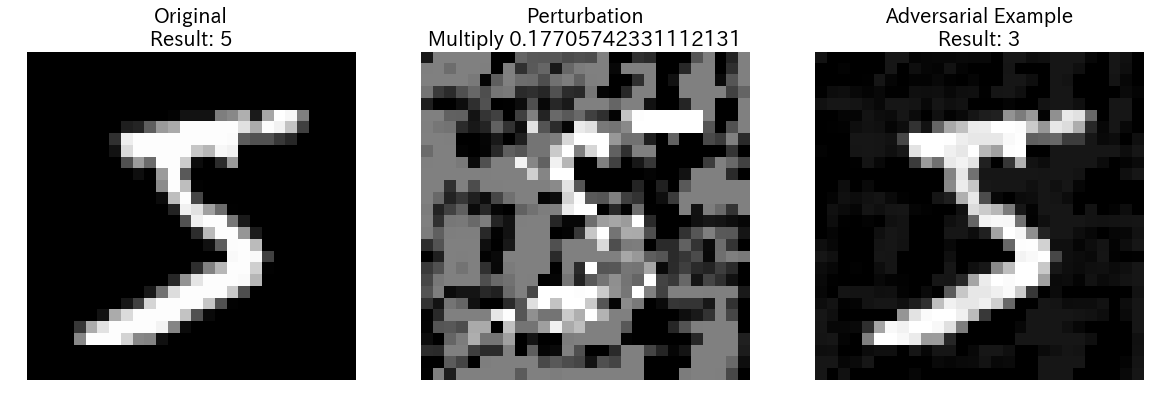

In [14]:
fig = plt.figure(figsize=(20, 10))

left = fig.add_subplot(131)
left.imshow(mnist.train_data[idx].numpy().squeeze(), cmap='gray')
left.axis('off')
left.set_title(f'Original\nResult: {y_true_np}', fontdict = {"fontproperties": fontprop, "fontsize": 20})

multiply = (np.max(noise) - np.min(noise)) / 255
middle = fig.add_subplot(132)
middle.imshow(noise, cmap='gray')
middle.axis('off')
middle.set_title(f'Perturbation\nMultiply {multiply}', fontdict = {"fontproperties": fontprop, "fontsize": 20})

right = fig.add_subplot(133)
right.imshow(adv_img, cmap='gray')
right.axis('off')
right.set_title(f'Adversarial Example\nResult: {adv_pred}', fontdict = {"fontproperties": fontprop, "fontsize": 20})